In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df_cleaned_drop_IF = pd.read_csv('./Data/cleaned_drop_IF.csv')
df_cleaned_drop_IQR = pd.read_csv('./Data/cleaned_drop_IQR.csv')
df_cleaned_mean_IF = pd.read_csv('./Data/cleaned_mean_IF.csv')
df_cleaned_mean_IQR = pd.read_csv('./Data/cleaned_mean_IQR.csv')
df_cleaned_median_IF = pd.read_csv('./Data/cleaned_median_IF.csv')
df_cleaned_median_IQR = pd.read_csv('./Data/cleaned_median_IQR.csv')

In [3]:
df_cleaned_drop_IF.columns

Index(['from_airport_code', 'from_country', 'dest_airport_code',
       'dest_country', 'aircraft_type', 'airline_number', 'airline_name',
       'flight_number', 'departure_time', 'arrival_time', 'duration', 'stops',
       'price', 'currency', 'co2_emissions', 'avg_co2_emission_for_this_route',
       'co2_percentage', 'scan_date'],
      dtype='object')

In [4]:
# df_cleaned_drop_IF.head(3)
print(df_cleaned_drop_IF.head(1))

  from_airport_code from_country dest_airport_code dest_country  \
0               YYZ       Canada               ADD     Ethiopia   

                                      aircraft_type airline_number  \
0  Airbus A220-300 Passenger|Boeing 777|Airbus A350          multi   

              airline_name      flight_number       departure_time  \
0  [Air Canada| Ethiopian]  AC418|AC418|AC418  2022-05-02 16:00:00   

          arrival_time  duration  stops  price currency  co2_emissions  \
0  2022-05-04 06:00:00      1860      2  820.0      USD      1089000.0   

   avg_co2_emission_for_this_route  co2_percentage            scan_date  
0                        1126000.0            -3.0  2022-04-29 17:52:59  


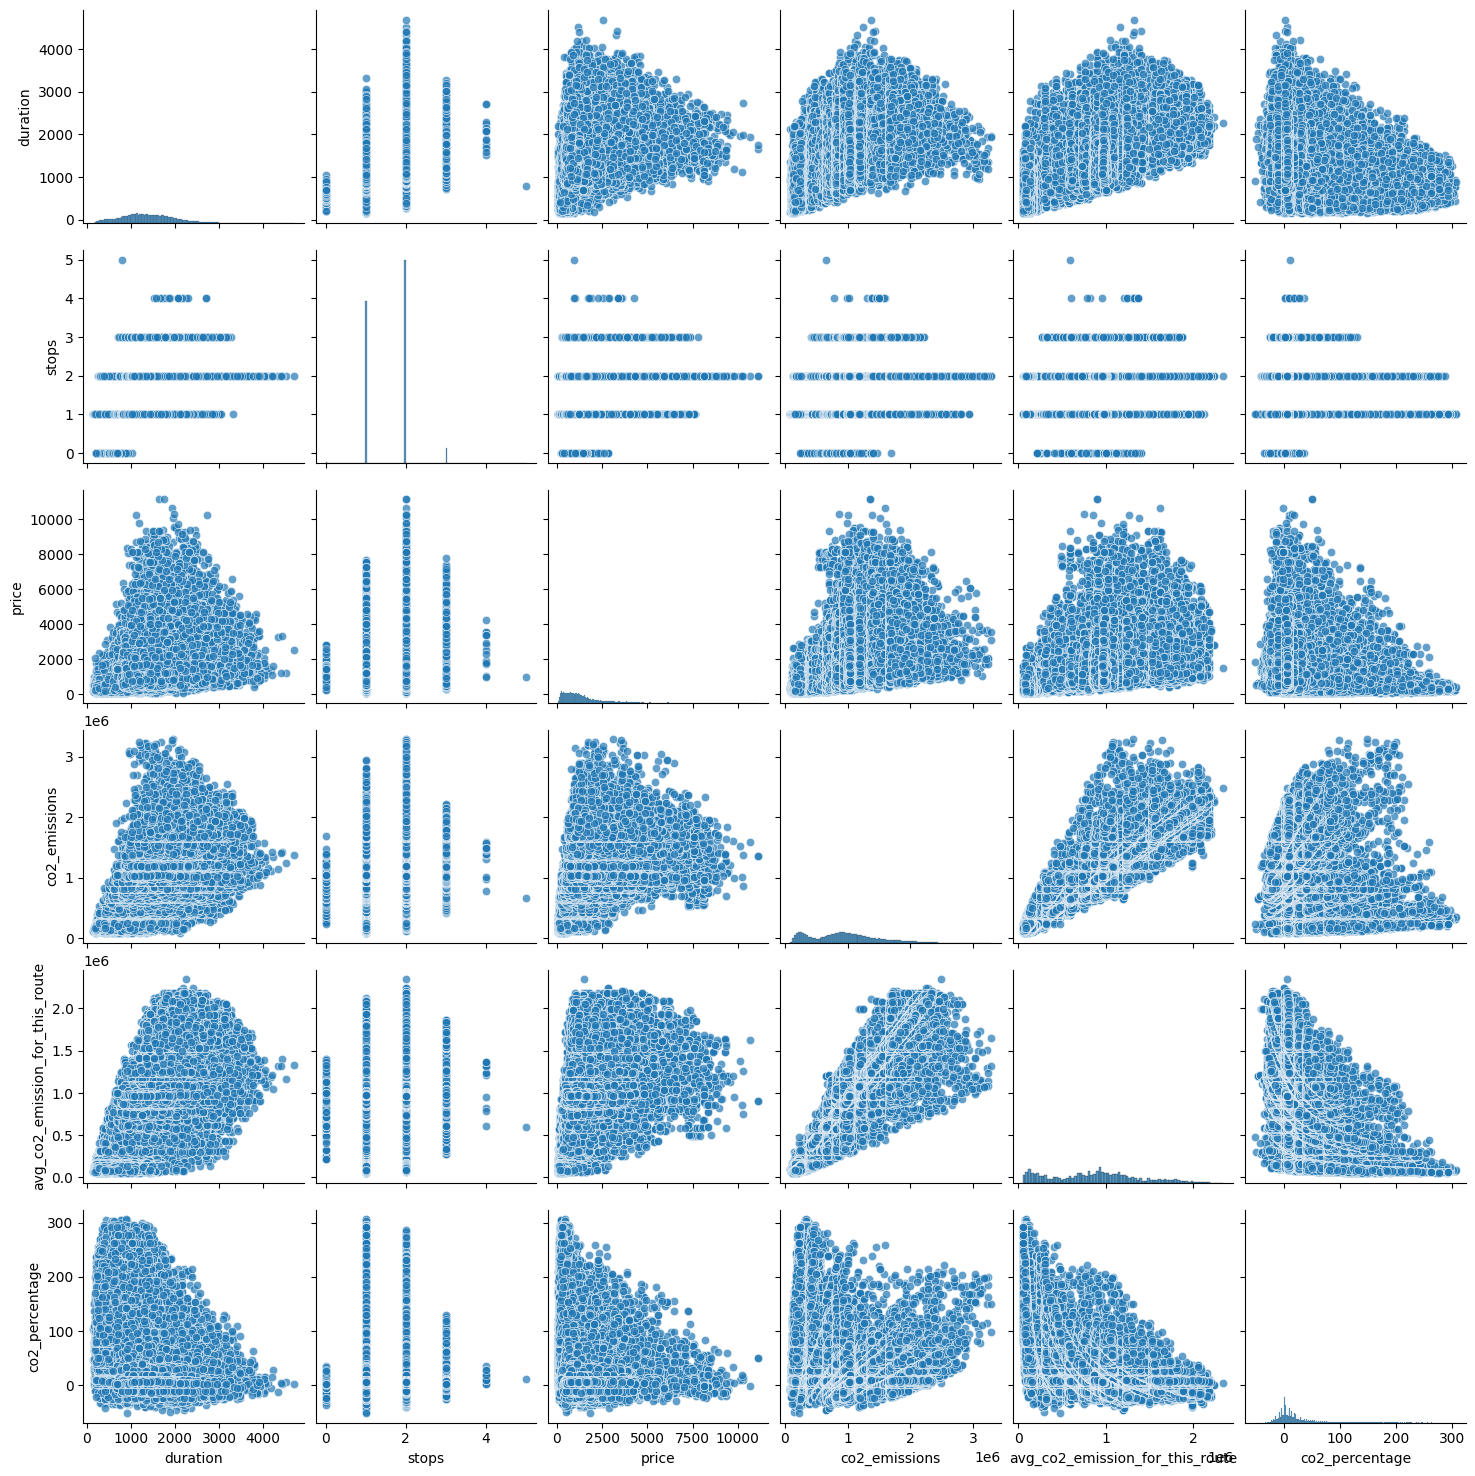

In [5]:

import seaborn as sns

features = ['duration', 'stops', 'price', 'co2_emissions', 'avg_co2_emission_for_this_route', 'co2_percentage']

sns.pairplot(
    df_cleaned_drop_IF,
    vars=features,
    #              hue='species',
    #              markers=['o', 'D', '+'],
    plot_kws={"alpha": 0.7},
);

In [6]:
import numpy as np

conditions = [
    # Not sustainable: high CO2 or many stops or old aircraft
    (df_cleaned_drop_IF['co2_percentage'] > 0) & 
    (df_cleaned_drop_IF['stops'] > 1) ,
    
    # Pretty sustainable: slightly better CO2 and at most 1 stop
    (df_cleaned_drop_IF['co2_percentage'] > -10) & (df_cleaned_drop_IF['co2_percentage'] <= 0), 
    
    # Sustain: low CO2 and modern aircraft
    (df_cleaned_drop_IF['co2_percentage'] <= -10)
]

choices = ['not sustain', "pretty sustain", 'sustain']

df_cleaned_drop_IF['status'] = np.select(conditions, choices, default='unknown')

df_cleaned_drop_IF[ 'status'].value_counts()

status
not sustain       39830
unknown           30329
pretty sustain    19687
sustain           10149
Name: count, dtype: int64

In [7]:
print(df_cleaned_drop_IF['aircraft_type'].unique())

['Airbus A220-300 Passenger|Boeing 777|Airbus A350'
 'Airbus A330|Airbus A320|Boeing 787' 'Boeing 737|Boeing 787' ...
 'Boeing 737|Boeing 777|Bombardier Regional Jet 550'
 'Embraer 195|Airbus A220-100 Passenger|Boeing 787'
 'Airbus A320|Embraer 190 E2|Boeing 787']


In [8]:
import numpy as np

conditions = [
    # Not sustain: high CO2 or more than 1 stop
    (df_cleaned_drop_IQR['co2_percentage'] > 0) | (df_cleaned_drop_IQR['stops'] > 1),

    # Pretty sustain: slightly better CO2 (within -10%) and at most 1 stop
    (df_cleaned_drop_IQR['co2_percentage'] > -10) & 
    (df_cleaned_drop_IQR['co2_percentage'] <= 0) & 
    (df_cleaned_drop_IQR['stops'] <= 1),

    # Sustain: very low CO2 and nonstop or one-stop flight
    (df_cleaned_drop_IQR['co2_percentage'] <= -10) & 
    (df_cleaned_drop_IQR['stops'] <= 1)
]

choices = ['not sustain', 'pretty sustain', 'sustain']

df_cleaned_drop_IQR['status'] = np.select(conditions, choices, default='unknown')
df_cleaned_drop_IQR['status'].value_counts()


status
not sustain       86106
pretty sustain     8442
sustain            5451
Name: count, dtype: int64

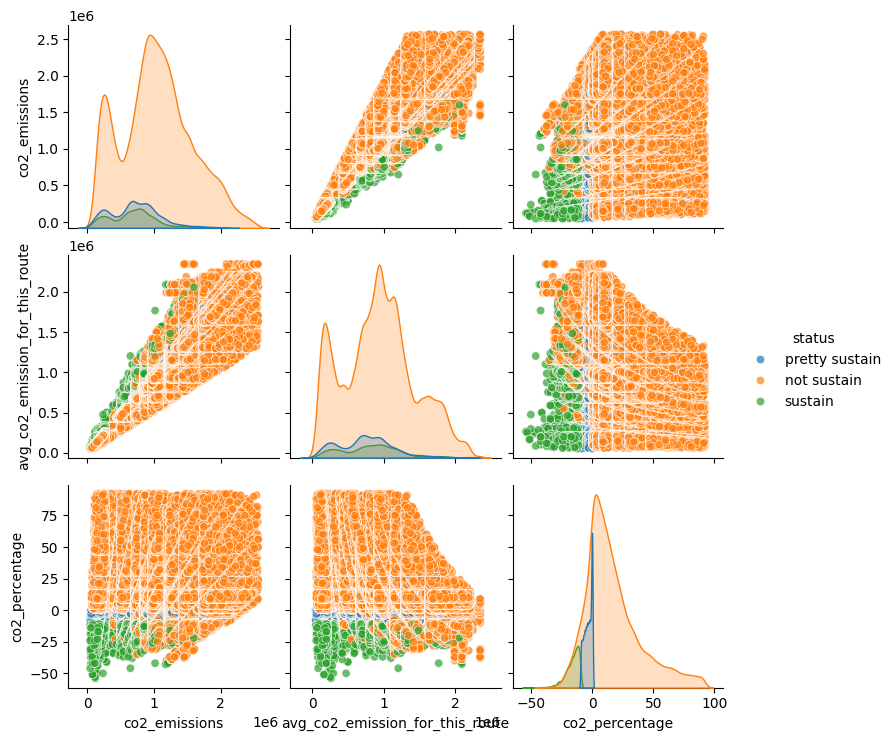

In [9]:
import seaborn as sns

features = ['co2_emissions', 'avg_co2_emission_for_this_route', 'co2_percentage']

sns.pairplot(
    df_cleaned_drop_IQR,
    vars=features,
    hue='status',  # Add this line to label by status
    plot_kws={"alpha": 0.7}
);


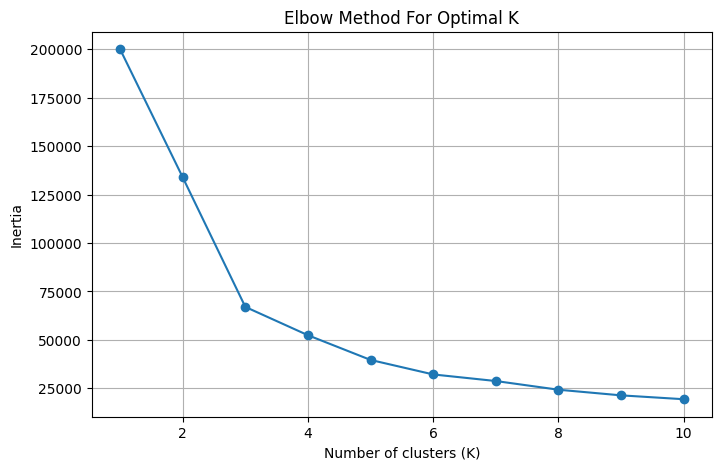

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame
features = ['price', 'co2_percentage']
X = df_cleaned_drop_IF[features].dropna()  # Drop missing values if any

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method
inertia = []
K_range = range(1, 11)  # Trying K from 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)  # Sum of squared distances to closest cluster center

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


c:\Users\punna\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3593 (\N{THAI CHARACTER CHO CHING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


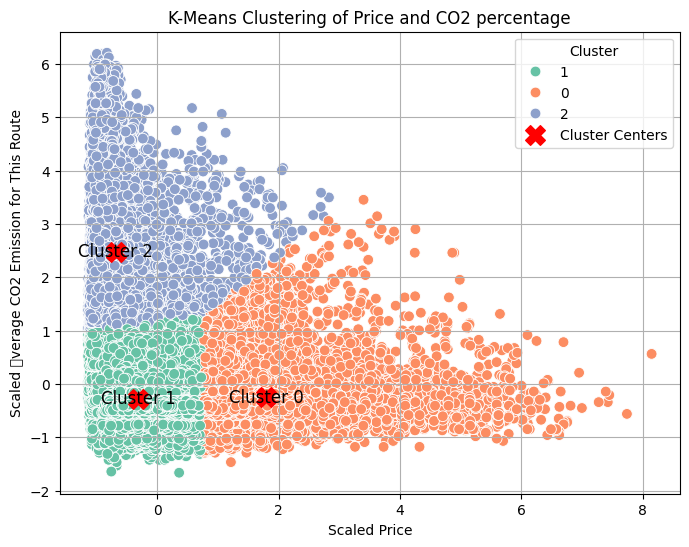

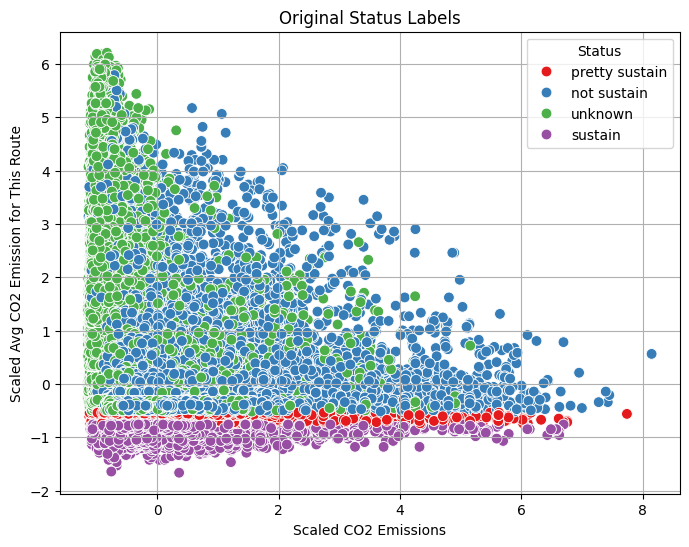

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare the data
features = ['price', 'co2_percentage']
df_plot = df_cleaned_drop_IF[features + ['status']].dropna()

# Step 2: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_plot[features])

# Step 3: Apply K-Means (choose K=3 as an example)
k = 3  # You can change this based on elbow method
kmeans = KMeans(n_clusters=k, random_state=42)
df_plot['cluster'] = kmeans.fit_predict(X_scaled)

# Step 4a: Plot K-Means clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_scaled[:, 0],
    y=X_scaled[:, 1],
    hue=df_plot['cluster'].astype(str),
    palette='Set2',
    s=60
)
# Add cluster centers
cluster_centers = kmeans.cluster_centers_
plt.scatter(
    cluster_centers[:, 0], cluster_centers[:, 1],
    marker='X', color='red', s=200, label='Cluster Centers'
)

# Optionally, annotate cluster centers with labels
for i, center in enumerate(cluster_centers):
    plt.text(
        center[0], center[1], f'Cluster {i}', color='black', 
        fontsize=12, ha='center', va='center'
    )
    
plt.title('K-Means Clustering of Price and CO2 percentage')
plt.ylabel('Scaled ฉverage CO2 Emission for This Route')
plt.xlabel('Scaled Price')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Step 4b: Plot by original status (for comparison)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_scaled[:, 0],
    y=X_scaled[:, 1],
    hue=df_plot['status'],
    palette='Set1',
    s=60
)
plt.title('Original Status Labels')
plt.xlabel('Scaled CO2 Emissions')
plt.ylabel('Scaled Avg CO2 Emission for This Route')
plt.legend(title='Status')
plt.grid(True)
plt.show()


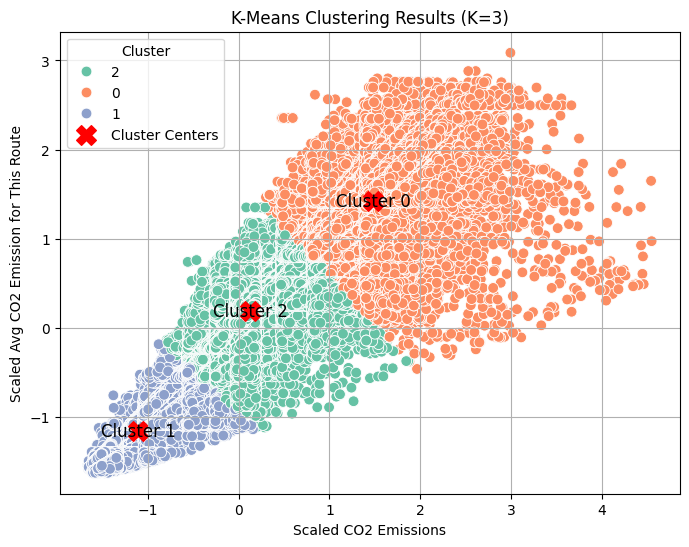

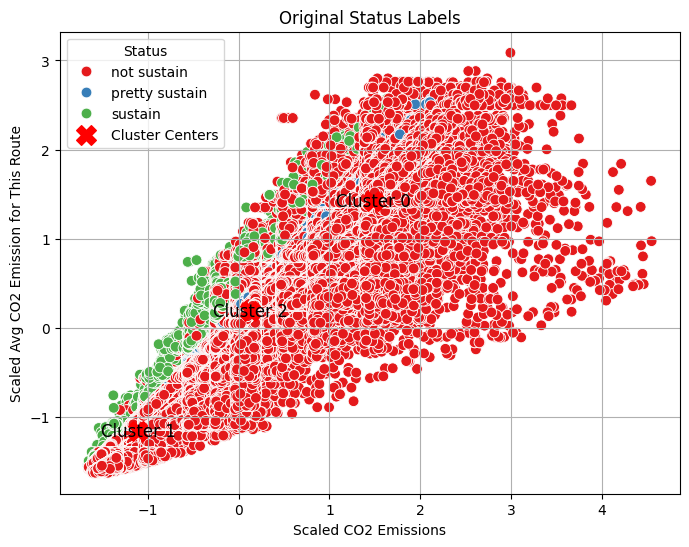

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming 'df_cleaned_drop_IF' is your cleaned DataFrame
# Step 1: Prepare the data
features = ['co2_emissions', 'avg_co2_emission_for_this_route']
df_plot = df_cleaned_drop_IF[features + ['status']].dropna()

# Step 2: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_plot[features])

# Step 3: Apply K-Means (choose K=3 as an example)
k = 3  # You can change this based on elbow method
kmeans = KMeans(n_clusters=k, random_state=42)
df_plot['cluster'] = kmeans.fit_predict(X_scaled)

# Step 4a: Plot K-Means clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_scaled[:, 0],
    y=X_scaled[:, 1],
    hue=df_plot['cluster'].astype(str),  # Color by cluster
    palette='Set2',
    s=60
)

# Add cluster centers
cluster_centers = kmeans.cluster_centers_
plt.scatter(
    cluster_centers[:, 0], cluster_centers[:, 1],
    marker='X', color='red', s=200, label='Cluster Centers'
)

# Optionally, annotate cluster centers with labels
for i, center in enumerate(cluster_centers):
    plt.text(
        center[0], center[1], f'Cluster {i}', color='black', 
        fontsize=12, ha='center', va='center'
    )

# Step 5: Add Titles, Labels, and Legend
plt.title(f'K-Means Clustering Results (K={k})')
plt.xlabel('Scaled CO2 Emissions')
plt.ylabel('Scaled Avg CO2 Emission for This Route')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Step 4b: Plot by original status (for comparison)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_scaled[:, 0],
    y=X_scaled[:, 1],
    hue=df_plot['status'],  # Color by original status
    palette='Set1',
    s=60
)

# Add cluster centers to the second plot as well
plt.scatter(
    cluster_centers[:, 0], cluster_centers[:, 1],
    marker='X', color='red', s=200, label='Cluster Centers'
)

# Optionally, annotate cluster centers with labels
for i, center in enumerate(cluster_centers):
    plt.text(
        center[0], center[1], f'Cluster {i}', color='black', 
        fontsize=12, ha='center', va='center'
    )

# Add Titles, Labels, and Legend
plt.title('Original Status Labels')
plt.xlabel('Scaled CO2 Emissions')
plt.ylabel('Scaled Avg CO2 Emission for This Route')
plt.legend(title='Status')
plt.grid(True)
plt.show()



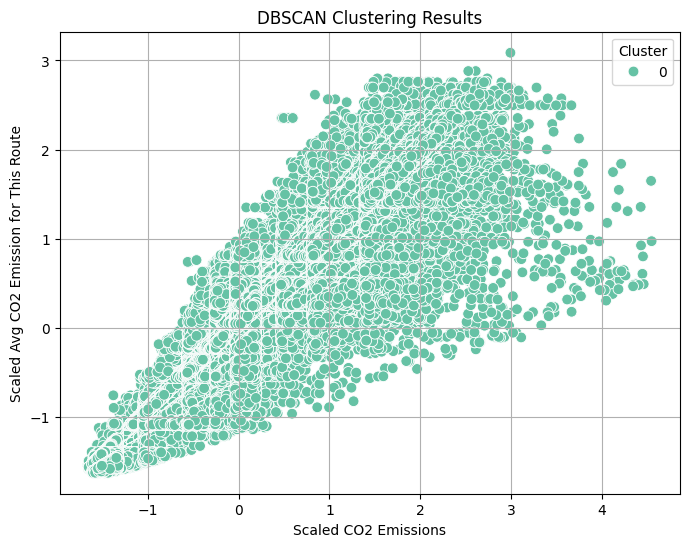

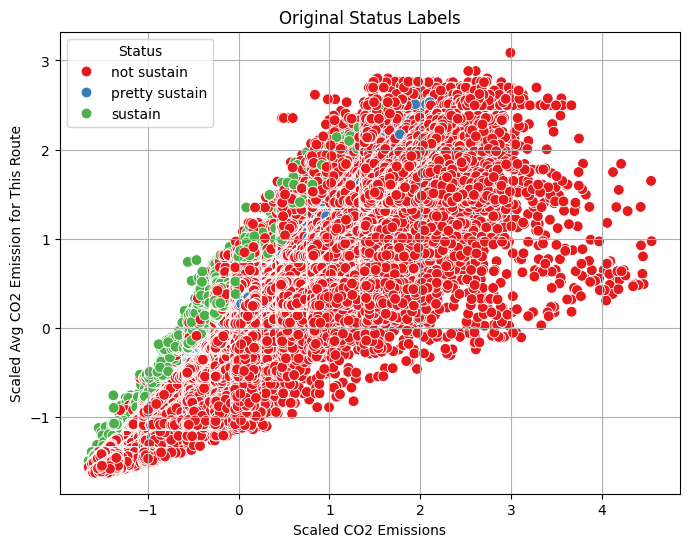

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare the data
features = ['co2_emissions', 'avg_co2_emission_for_this_route']
df_plot = df_cleaned_drop_IF[features + ['status']].dropna()

# Step 2: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_plot[features])

# Step 3: Apply DBSCAN
# You may need to tune eps and min_samples for your data
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_plot['cluster'] = dbscan.fit_predict(X_scaled)

# Step 4a: Plot DBSCAN clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_scaled[:, 0],
    y=X_scaled[:, 1],
    hue=df_plot['cluster'].astype(str),
    palette='Set2',
    s=60
)
plt.title('DBSCAN Clustering Results')
plt.xlabel('Scaled CO2 Emissions')
plt.ylabel('Scaled Avg CO2 Emission for This Route')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Step 4b: Plot by original status (for comparison)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_scaled[:, 0],
    y=X_scaled[:, 1],
    hue=df_plot['status'],
    palette='Set1',
    s=60
)
plt.title('Original Status Labels')
plt.xlabel('Scaled CO2 Emissions')
plt.ylabel('Scaled Avg CO2 Emission for This Route')
plt.legend(title='Status')
plt.grid(True)
plt.show()
